In [259]:
import numpy as np
from scipy.interpolate import splrep
from scipy.optimize import minimize
import inspect 

def clean_knots(x,knots):
    '''This function cleans an array of knots, removing those where
    no element of x is present
    '''
    h = np.histogram(x,bins=knots)[0]
    sel = np.concatenate(([True], h>0))
    return(knots[sel])


class FiniteSizeScaling():
    ''' This class groups methods to do finite-size scaling of x (Nx3 or Nx4), 
        where columns are x_i, y_i, (dy_i), L_i, and expected law 
        y_i = f(map(x_i)).
        
        inputs: 
            x : array of N elements or Nx3, Nx4 matrix with columns corresponding to x_i,y_i
            y:
            dy:
            L: 
            mapx: 
    '''
    def __init__(self, x, y = None,  L = None, dy = None, mapx = None, ncoef = 2):
        # Checks for x and y should be here
        
        # Check for repeated xs
        
        # If all the data is in x:
        if y is  None:
            self.x = x[:,0]
            self.N = self.x.shape[0]
            self.y = x[:,1] 
            self.L = x[:,-1]
            if x.shape[1]>3:
                self.dy = 1.0/x[:,2]**2
            else:
                self.dy = np.ones(self.N)
        else:
            self.x = np.array(x)
            self.N = self.x.shape[0]
            self.y = np.array(y)
            if L is None:
                print('No sizes were given!')
                raise ValueError
            else:
                self.L = np.array(L)
            if dy is None:
                self.dy = np.ones(self.N)
            else:
                self.dy = 1.0/np.array(dy)**2
                
        if inspect.isfunction(mapx):
            self.mapx = mapx
        else:
            self.mapx = self.transform0
        
        self.ncoef = ncoef
        self.coefs = np.zeros(self.ncoef)
        self.xscaled = np.zeros((self.N,3))
        
    def prefit(self, coefs0 = None):
        ''' Preparing the dataset with coefficients coefs0, sorting 
            and avoiding repeated points
        '''
        if coefs0 is None:
            coefs0 = np.random.randn(self.ncoef)
        xscaled = self.mapx(coefs0)
        if len(set(xscaled[:,0]))<self.N:
            print('Warning: repeated x_i,L_i!')
        xscaled[:,0] = xscaled[:,0]*(1.0+np.random.randn(self.N)*1e-8)
        xscaled.sort(axis=0)
        self.xscaled = xscaled
        return xscaled
    
    def fit(self,coefs0 = None,nknots = 21):
        value = self.prefit(coefs0)
        #if value!=0:
        #    print('Error preparing the data!')
        #    raise RuntimeError
            
        minx = self.findscaling(coefs0,21)
        print(minx)

        self.xscaled = self.mapx(minx.x)
        return
    
    def errorbars_bootstrap(self,n_coef = None):
        print('Not implemented yet')
        pass
        return
    
    def plot_scaleddata(self,ax = None,figsize = (7,5)):
        if ax is None:
            fig = plt.figure(figsize = figsize )
            ax  = fig.add_subplot(111)
            xscaled = self.mapx(self.minx.x)
            for Lp in set(self.L):
                sel = self.L==Lp
                xt = xscaled[sel,:2]
                xt.sort(axis=0)
                ax.plot(xt[:,0],xt[:,1],'.-',label=Lp)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.legend() 
        return
    
    def findscaling(self,coefs0 = None, nknots = 21):  
        ''' Method to find the scaling, we define a chi2 function and minimize it
           nknots: number of knots for the cubic B spline function
        '''
        def chi2(cf):
            xscaled = self.prefit(cf)
            xtx,xty,xdy = xscaled[:,0],xscaled[:,1],xscaled[:,2]
            knots = np.linspace(min(xtx)+1e-6,max(xtx)-1e-6,nknots)
            knots = clean_knots(xtx,knots)

            try:
                yspl,f2,ie,ms = splrep(xtx,xty,t=knots,
                                   k=3,full_output=1, w= xdy)
            except Exception as e:
                print('Exception building splines:', e)
            if ie>0:
                print('Exception but not raised!', ie,ms)
            return f2 #,ie,ms
        print(coefs0, chi2(coefs0))
        try:
            minx = minimize(chi2,coefs0,method = 'Nelder-Mead')
        except Exception as e: 
            print("Exception: ",e)
            return
        print(minx)
        self.minx = minx
        ie = self.prefit(minx.x)
        return(minx)
        
    def transform0(self,coefs):
        ''' Basic transformation of the data'''
        xscaled = np.zeros((self.N,3))
        xscaled[:,0] = (self.x-coefs[0])*self.L**coefs[1]
        xscaled[:,1] = self.y
        xscaled[:,2] = self.dy
        return(xscaled)

In [260]:
import matplotlib.pylab as plt
%matplotlib inline

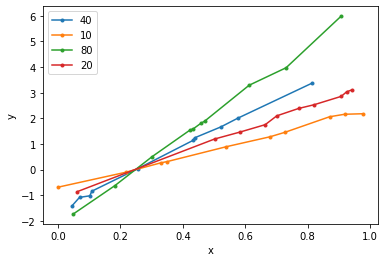

In [261]:
xs = np.random.rand(10*4)
Ls = 10*2**(np.arange(40)//10)
ys = ((xs-0.25)*Ls**0.5)*(1.0+np.random.randn(xs.shape[0])*0.05)
for L in set(Ls):
    sel = Ls==L
    xt = np.column_stack((xs[sel],ys[sel]))
    xt.sort(axis=0)
    plt.plot(xt[:,0],xt[:,1],'.-',label=L)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [262]:
datafss = FiniteSizeScaling(xs,ys,Ls,ys*0.1)

In [265]:
coefs0 = np.array([0.25,0.5])
datafss.fit(coefs0,nknots = 21)

[0.25 0.5 ] 511.8198492861893
 final_simplex: (array([[0.30355964, 0.64718737],
       [0.30356708, 0.64719974],
       [0.30357424, 0.64721135]]), array([215.83243674, 215.83247473, 215.83252335]))
           fun: 215.83243673521247
       message: 'Optimization terminated successfully.'
          nfev: 111
           nit: 57
        status: 0
       success: True
             x: array([0.30355964, 0.64718737])
 final_simplex: (array([[0.30355964, 0.64718737],
       [0.30356708, 0.64719974],
       [0.30357424, 0.64721135]]), array([215.83243674, 215.83247473, 215.83252335]))
           fun: 215.83243673521247
       message: 'Optimization terminated successfully.'
          nfev: 111
           nit: 57
        status: 0
       success: True
             x: array([0.30355964, 0.64718737])


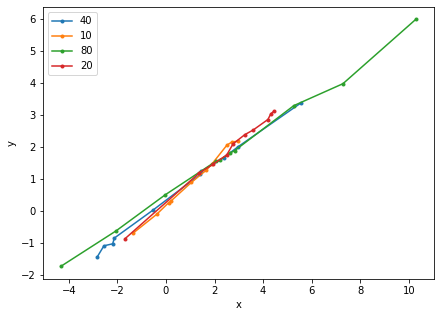

In [266]:
datafss.plot_scaleddata()

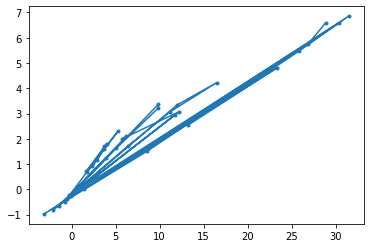

In [247]:
plt.plot(datafss.xscaled[:,0],datafss.xscaled[:,1],'.-')